In [1]:
import os
from joblib import Parallel, delayed
from typing import Tuple

from qiskit.circuit import QuantumRegister, Parameter
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import X, Y
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
import numpy as np
from qiskit.circuit.library import PauliEvolutionGate


import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

C:\Users\madse\AppData\Local\Temp\ipykernel_20428\3041581449.py:8: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y


In [2]:
# Number of Qubits 
N=8
# Number of excitations
k=4
# RNG seed for reproducibility
seed=1
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=400
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

 Qubit indices in chain: 
 [0 1 2 3 4 5 6 7]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)]

 Initialization strategy is: 
 [0 1 0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [3]:
# Deciding between grid and 1d chain topology
my_topology = my_chain
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")


Min. cost portfolio (constrained subspace): 10.786376008825837
Optimal portfolio state (constrained subspace) is: |01100110>
Min. cost QUBO: 10.786376008825869
Min. cost QUBO state is: |01100110>


In [4]:
print("Check that qubo min cost is same as portfolio min cost:")
qubo_min_cost, portfolio_subspace_min_cost

Check that qubo min cost is same as portfolio min cost:


(10.786376008825869, 10.786376008825837)

In [5]:
print("Check that qubo max cost is at least portfolio max cost:")
qubo_max_cost, portfolio_subspace_max_cost

Check that qubo max cost is at least portfolio max cost:


(230.6842057753166, 18.712909053266962)

In [6]:
# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_gradient=True,
                 with_z_phase=False)

In [7]:
# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * len(my_topology.get_NNN_indices())
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

COST = CP_z_phase_ansatz.get_cost(angles=CP_z_phase_theta_i)
COST

-2.5921315353912173

In [8]:
probs = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)

In [9]:
def create_state_vector(state_str: str, probability: float) -> np.ndarray:
    # Create a zero vector with length 2^N
    state_vector = np.zeros(2**len(state_str), dtype=np.float64)
    # Set the amplitude for the specified state
    state_vector[int(state_str, 2)] = np.sqrt(probability)
    return state_vector

def create_operator(Q: np.ndarray):
    """Creates H=\sum_i E_i |i><i|"""
    
    N = Q.shape[0]
    def generate_binary_permutations(n: int) -> Tuple[np.ndarray, str]:
        """ Generates all the 2^n permutations of bitstring w. length 'n'. """
        num_permutations = 2 ** n
        for i in range(num_permutations):
            _binary_string_ = bin(i)[2:].zfill(n)
            yield np.array([int(bit) for bit in _binary_string_]), _binary_string_
    def qubo_cost(state: np.ndarray, QUBO_matrix: np.ndarray) -> float:
        return np.dot(state, np.dot(QUBO_matrix, state))
    operator = np.zeros(shape=(2**N,2**N), dtype=np.float64)
    for (array_perm, string_perm) in generate_binary_permutations(n=N):
        E_i = qubo_cost(state=array_perm,QUBO_matrix=Q)
        state_vector = create_state_vector(state_str=string_perm, probability=1.0)
        operator += E_i * np.outer(state_vector, state_vector)
    return operator       

def operator_expectation(O: np.ndarray, probability_dict: dict):
    vals = []
    for (binary_state_str, probability) in probability_dict.items():
        state_vector = create_state_vector(state_str=binary_state_str, probability=probability)
        vals.append(state_vector.T.conj() @ (O @ state_vector))
    return np.mean(vals)

In [10]:
O = create_operator(Q=Q)

In [11]:
operator_expectation(O,probs)

-2.5921315353912173

In [12]:
from typing import List
from qiskit.quantum_info import Operator, SparsePauliOp

def get_ij_term(i:int, j:int, Q: np.ndarray) -> List[Tuple[str,float]]:
    N = Q.shape[0]
    I_term = ''.join('I' for qubit_idx in range(N))
    Z_i_term = ''.join('Z' if qubit_idx == i else 'I' for qubit_idx in range(N)) 
    Z_j_term = ''.join('Z' if qubit_idx == i else 'I' for qubit_idx in range(N))
    # Pauli matrices are idempotent: x^2=y^2=z^2=I
    if i == j:
        Z_ij_term = I_term
    else:
        Z_ij_term = ''.join('Z' if qubit_idx == i  or qubit_idx == j else 'I' for qubit_idx in range(N)) 
    total_ij_term = [(I_term,Q[i,j]/4),(Z_i_term,-Q[i,j]/4), (Z_j_term,-Q[i,j]/4),(Z_ij_term,Q[i,j]/4)]
    return total_ij_term


In [13]:
H = []
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        H += get_ij_term(i,j,Q)
H = SparsePauliOp.from_list(H)

In [14]:
np.allclose(np.array(Operator(H)),O)

True

In [15]:
def get_pauli_hamiltonian(Q: np.ndarray):
    H = []
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            H += get_ij_term(i,j,Q)
    return SparsePauliOp.from_list(H)

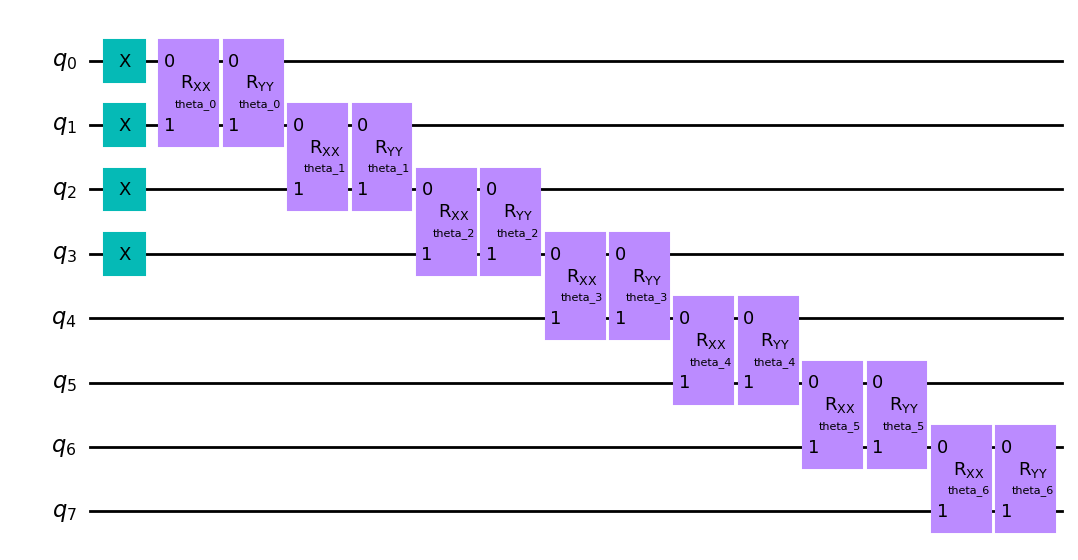

In [17]:
thetas = np.random.uniform(-4*np.pi,4*np.pi,7).tolist()
params = [Parameter(f'theta_{i}') for i in range(len(thetas))]
qc = QuantumCircuit(8)
k=4
for i in range(k):
    qc.x(i)
for q in range(7):
    qc.rxx(params[q],q,q+1)
    qc.ryy(params[q],q,q+1)
qc.draw('mpl')

In [18]:


#Instantiate the Hamiltonian observable 2X+Y
H = get_pauli_hamiltonian(Q)

#Parameter list
param_values = [[theta for theta in thetas]]

#Define the gradient
gradient = ParamShiftEstimatorGradient(Estimator())

# Evaluate the gradient of the circuits using parameter shift gradients
pse_grad_result = gradient.run(circuits=qc, 
                               observables=H,
                               parameter_values=param_values).result().gradients
pse_grad_result

[array([ 2.84217094e-14,  0.00000000e+00,  0.00000000e+00,  2.17464996e+00,
        -4.16034009e-01, -1.32380969e-01, -2.38705927e-02])]

In [19]:
norms = []
for seed in tqdm(range(100)):
    np.random.seed(seed)
    thetas = np.random.uniform(-4*np.pi,4*np.pi,7).tolist()
    params = [Parameter(f'theta_{i}') for i in range(len(thetas))]
    qc = QuantumCircuit(8)
    for i in range(k):
        qc.x(i)
    for q in range(7):
        qc.rxx(params[q],q,q+1)
        qc.ryy(params[q],q,q+1)
    #Instantiate the Hamiltonian observable 2X+Y
    H = get_pauli_hamiltonian(Q)
    
    #Parameter list
    param_values = [[theta for theta in thetas]]
    
    #Define the gradient
    gradient = ParamShiftEstimatorGradient(Estimator())
    
    # Evaluate the gradient of the circuits using parameter shift gradients
    pse_grad_result = gradient.run(circuits=qc, 
                                   observables=H,
                                   parameter_values=param_values).result().gradients
    norms.append(np.linalg.norm(pse_grad_result))

100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


(array([ 4.,  8.,  6., 14., 14., 16., 13., 11.,  7.,  7.]),
 array([0.04711873, 0.31646299, 0.58580724, 0.8551515 , 1.12449576,
        1.39384002, 1.66318427, 1.93252853, 2.20187279, 2.47121705,
        2.7405613 ]),
 <BarContainer object of 10 artists>)

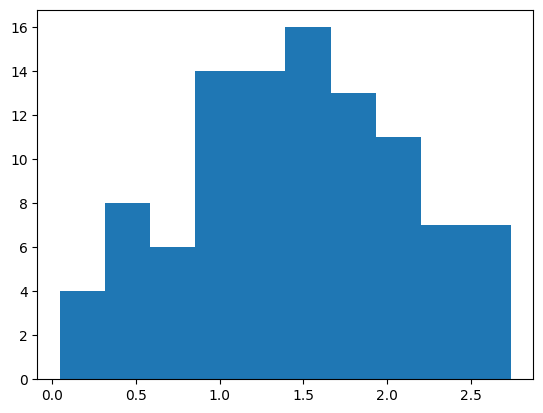

In [20]:
plt.hist(norms)